# 稀疏性和L1正则化

 **学习目标：**
  * 计算模型大小
  * 通过应用 L1 正则化来增加稀疏性，以减小模型大小
  
降低复杂性的一种方法是使用正则化函数，它会使权重正好为零。对于线性模型（例如线性回归），权重为零就相当于完全没有使用相应特征。除了可避免过拟合之外，生成的模型还会更加有效。

L1 正则化是一种增加稀疏性的好方法。

## 设置

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [4]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [5]:
# 训练集
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# 验证集
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2630.4,537.1,1426.1,499.3,3.9,2.0
std,2.1,2.0,12.6,2162.5,416.9,1155.9,379.7,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.0,297.0,786.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.0,433.0,1166.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3131.2,649.0,1724.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2675.5,545.0,1437.8,505.9,3.9,2.0
std,2.1,2.0,12.6,2221.3,432.3,1128.4,395.8,1.9,1.2
min,32.5,-124.2,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,296.0,796.8,282.0,2.6,1.5
50%,34.2,-118.5,28.0,2142.5,435.0,1169.0,411.0,3.5,1.9
75%,37.7,-118.0,37.0,3193.0,648.0,1714.0,599.0,4.8,2.3
max,42.0,-114.6,52.0,32054.0,5290.0,15507.0,5050.0,15.0,52.0


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def get_quantile_based_buckets(feature_values, num_buckets):
    quantiles = feature_values.quantile(
        [(i+1.) / (num_buckets + 1.) for i in range(num_buckets)])
    return [quantiles[q] for q in quantiles.keys()]

In [10]:
def construct_feature_columns():
    bucketized_households = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column('households'),
        boundaries=get_quantile_based_buckets(training_examples['households'], 10))
    bucketized_longitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("longitude"),
        boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
    bucketized_latitude = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("latitude"),
        boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
    bucketized_housing_median_age = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("housing_median_age"),
        boundaries=get_quantile_based_buckets(training_examples["housing_median_age"], 10))
    bucketized_total_rooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_rooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
    bucketized_total_bedrooms = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("total_bedrooms"),
        boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
    bucketized_population = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("population"),
        boundaries=get_quantile_based_buckets(training_examples["population"], 10))
    bucketized_median_income = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("median_income"),
        boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
    bucketized_rooms_per_person = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column("rooms_per_person"),
        boundaries=get_quantile_based_buckets(training_examples["rooms_per_person"], 10))

    long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

    feature_columns = set([
        long_x_lat,
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_total_rooms,
        bucketized_total_bedrooms,
        bucketized_population,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])

    return feature_columns

## 计算模型大小

要计算模型大小，只需计算非零参数的数量即可。为此，我们在下面提供了一个辅助函数。该函数深入使用了 Estimator API

In [16]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        if not any(x in variable 
                   for x in ['global_step',
                             'centered_bias_weight',
                             'bias_weight',
                             'Ftrl']
                  ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    return size

## 减小模型大小

使用L1正则化调整模型。

**目的** ：

   * 模型参数数量不能超过600个
   * 对数损失函数低于 0.35

### 查找合适的正则化系数

我们选择使用 FtrlOptimizer 来应用正则化。FtrlOptimizer 是一种设计成使用 L1 正则化比标准梯度下降法得到更好结果的方法。

In [23]:
%matplotlib inline
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    
    periods = 7
    steps_per_period = steps / periods

    # Create a linear regressor object.
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value_is_high"], 
        num_epochs=1, 
        shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period,
        )
        # 2. Take a break and compute predictions.
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)

        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.30
  period 01 : 0.27
  period 02 : 0.25
  period 03 : 0.24
  period 04 : 0.24
  period 05 : 0.23
  period 06 : 0.23
Model training finished.
Model size: 789


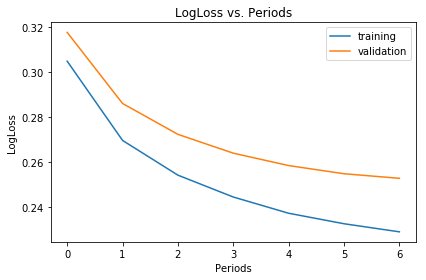

In [24]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=0.0,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

请注意，有一个需要做出折中选择的地方：正则化越强，我们获得的模型就越小，但会影响分类损失。

Training model...
LogLoss (on training data):
  period 00 : 0.31
  period 01 : 0.27
  period 02 : 0.26
  period 03 : 0.25
  period 04 : 0.24
  period 05 : 0.23
  period 06 : 0.23
Model training finished.
Model size: 759


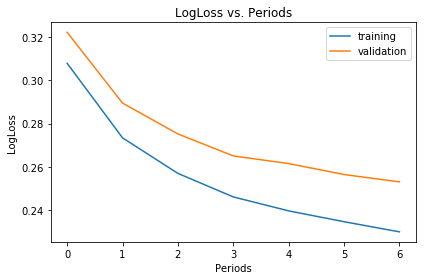

In [25]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (on training data):
  period 00 : 0.33
  period 01 : 0.29
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.25
  period 05 : 0.24
  period 06 : 0.24
Model training finished.
Model size: 547


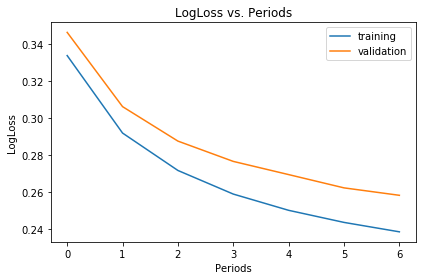

In [28]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (on training data):
  period 00 : 0.46
  period 01 : 0.38
  period 02 : 0.34
  period 03 : 0.31
  period 04 : 0.30
  period 05 : 0.29
  period 06 : 0.28
Model training finished.
Model size: 175


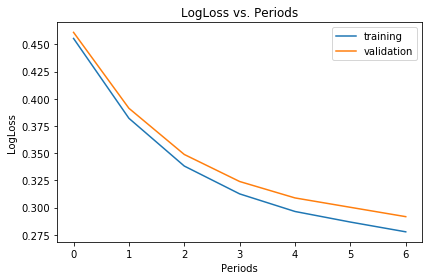

In [30]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=10,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))